In [1]:
import os
import time
from pprint import pprint

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
    
from catanatron_gym.envs.catanatron_env import ACTION_SPACE_SIZE
from catanatron_gym.features import get_feature_ordering

2022-01-30 08:39:05.704188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-30 08:39:05.704212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ===== Ensure datasets exists
import pathlib
import urllib.request

# Set appropriately in cloud environments
DOWNLOAD_FROM_INTERNET = False
DATA_FOLDER = "../../../data/vf-samemini-nodiscard-at-prediction"
VALIDATION_DATA = DATA_FOLDER + '-validation'

DATASET_PATH = pathlib.Path(DATA_FOLDER, "main.csv.gzip")
VALIDATION_DATASET_PATH = pathlib.Path(VALIDATION_DATA, "main.csv.gzip")

if DOWNLOAD_FROM_INTERNET:
    DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    VALIDATION_DATASET_PATH.parents[0].mkdir(parents=True, exist_ok=True)
    if not DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard/main.csv.gzip", DATASET_PATH)
    if not VALIDATION_DATASET_PATH.exists():
        urllib.request.urlretrieve("https://catanatron-public.s3.us-east-2.amazonaws.com/1v1-ab2s-nodiscard-validation/main.csv.gzip", VALIDATION_DATASET_PATH)

1608852 samples
13 classes
Counter({0: 609054, 12: 603917, 1: 111127, 11: 97887, 3: 88148, 4: 45419, 5: 20267, 6: 20168, 7: 9710, 8: 1556, 9: 1534, 10: 65})


<AxesSubplot:>

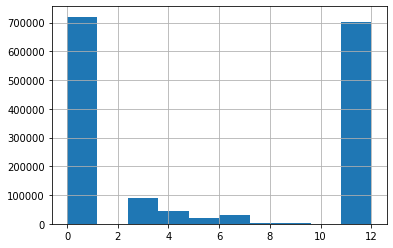

In [3]:
import pathlib
from collections import Counter

ACTIONS_DATASET_PATH = pathlib.Path(DATA_FOLDER, "actions.csv.gzip")
LABEL_COLUMN = "ACTION_TYPE"

df = pd.read_csv(ACTIONS_DATASET_PATH, compression="gzip")
NUM_SAMPLES = df.shape[0]
class_distribution = Counter(df[LABEL_COLUMN])
NUM_CLASSES = max(class_distribution.keys()) + 1
print(NUM_SAMPLES, 'samples')
print(NUM_CLASSES, 'classes')
print(class_distribution)
df[LABEL_COLUMN].hist()

In [4]:
data = pd.read_csv(DATASET_PATH, nrows=10, compression='gzip')
validation_data = pd.read_csv(VALIDATION_DATASET_PATH, nrows=10, compression='gzip')

def allow_feature(x):
    return x.startswith("F_") and not x.startswith("F_TILE")

INPUT_COLUMNS = list(filter(allow_feature, data.columns))
print(INPUT_COLUMNS)

assert (data.columns == validation_data.columns).all()
data[INPUT_COLUMNS]

['F_BANK_BRICK', 'F_BANK_DEV_CARDS', 'F_BANK_ORE', 'F_BANK_SHEEP', 'F_BANK_WHEAT', 'F_BANK_WOOD', 'F_EDGE(0, 1)_P0_ROAD', 'F_EDGE(0, 1)_P1_ROAD', 'F_EDGE(0, 20)_P0_ROAD', 'F_EDGE(0, 20)_P1_ROAD', 'F_EDGE(0, 5)_P0_ROAD', 'F_EDGE(0, 5)_P1_ROAD', 'F_EDGE(1, 2)_P0_ROAD', 'F_EDGE(1, 2)_P1_ROAD', 'F_EDGE(1, 6)_P0_ROAD', 'F_EDGE(1, 6)_P1_ROAD', 'F_EDGE(10, 11)_P0_ROAD', 'F_EDGE(10, 11)_P1_ROAD', 'F_EDGE(11, 12)_P0_ROAD', 'F_EDGE(11, 12)_P1_ROAD', 'F_EDGE(12, 13)_P0_ROAD', 'F_EDGE(12, 13)_P1_ROAD', 'F_EDGE(13, 14)_P0_ROAD', 'F_EDGE(13, 14)_P1_ROAD', 'F_EDGE(14, 15)_P0_ROAD', 'F_EDGE(14, 15)_P1_ROAD', 'F_EDGE(15, 17)_P0_ROAD', 'F_EDGE(15, 17)_P1_ROAD', 'F_EDGE(16, 18)_P0_ROAD', 'F_EDGE(16, 18)_P1_ROAD', 'F_EDGE(16, 21)_P0_ROAD', 'F_EDGE(16, 21)_P1_ROAD', 'F_EDGE(17, 18)_P0_ROAD', 'F_EDGE(17, 18)_P1_ROAD', 'F_EDGE(19, 20)_P0_ROAD', 'F_EDGE(19, 20)_P1_ROAD', 'F_EDGE(19, 21)_P0_ROAD', 'F_EDGE(19, 21)_P1_ROAD', 'F_EDGE(2, 3)_P0_ROAD', 'F_EDGE(2, 3)_P1_ROAD', 'F_EDGE(2, 9)_P0_ROAD', 'F_EDGE(2, 9)_P1

,F_BANK_BRICK,F_BANK_DEV_CARDS,F_BANK_ORE,F_BANK_SHEEP,F_BANK_WHEAT,F_BANK_WOOD,"F_EDGE(0, 1)_P0_ROAD","F_EDGE(0, 1)_P1_ROAD","F_EDGE(0, 20)_P0_ROAD","F_EDGE(0, 20)_P1_ROAD",...,F_P1_KNIGHT_PLAYED,F_P1_LONGEST_ROAD_LENGTH,F_P1_MONOPOLY_PLAYED,F_P1_NUM_DEVS_IN_HAND,F_P1_NUM_RESOURCES_IN_HAND,F_P1_PUBLIC_VPS,F_P1_ROADS_LEFT,F_P1_ROAD_BUILDING_PLAYED,F_P1_SETTLEMENTS_LEFT,F_P1_YEAR_OF_PLENTY_PLAYED
0,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0
1,19.0,25.0,19.0,19.0,19.0,19.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,5.0,0.0
2,17.0,25.0,19.0,19.0,18.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,13.0,0.0,3.0,0.0
3,17.0,25.0,19.0,19.0,18.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,13.0,0.0,3.0,0.0
4,17.0,25.0,19.0,19.0,18.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,13.0,0.0,3.0,0.0
5,17.0,25.0,19.0,19.0,18.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,13.0,0.0,3.0,0.0
6,17.0,25.0,19.0,19.0,18.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,13.0,0.0,3.0,0.0
7,18.0,25.0,19.0,19.0,18.0,19.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,12.0,0.0,3.0,0.0
8,18.0,25.0,19.0,19.0,18.0,19.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,12.0,0.0,3.0,0.0
9,18.0,25.0,19.0,19.0,18.0,19.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,2.0,12.0,0.0,3.0,0.0


In [5]:
# ===== Read Dataset
BATCH_SIZE = 128
SHUFFLE_SEED = 1

dataset = tf.data.experimental.make_csv_dataset(
    str(DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,  # shuffle will shuffle at the element level. nice.
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)
validation_dataset = tf.data.experimental.make_csv_dataset(
    str(VALIDATION_DATASET_PATH),
    batch_size=BATCH_SIZE,
    num_epochs=1,
    label_name=LABEL_COLUMN,
    select_columns=INPUT_COLUMNS + [LABEL_COLUMN],
    compression_type="GZIP",
    shuffle=True,
    shuffle_seed=1,
    shuffle_buffer_size=1000,
    prefetch_buffer_size=100,
)

def preprocess(batch, label):
    features = tf.stack(
        [tf.cast(tensor, tf.float32) 
         for feature_name, tensor in batch.items() 
         if feature_name in INPUT_COLUMNS
        ], axis=1
    )
    return features, tf.stack(label)

dataset = dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

2022-01-30 08:39:07.815801: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-30 08:39:07.858862: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-30 08:39:07.858897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bcollazo-Erazer-X510): /proc/driver/nvidia/version does not exist
2022-01-30 08:39:07.859516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# 10 takes 1sec. 100 batches take 4 secs. 1000 takes 50 secs.
t1 = time.time()
def take_samples(x, y):
    return x

normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalization_layer.adapt(dataset.map(take_samples).take(1000))
print("Normalization took:", time.time() - t1)
print(normalization_layer.mean)

2022-01-30 08:39:09.127651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-30 08:39:09.156580: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3492135000 Hz


Normalization took: 29.49730134010315
<tf.Variable 'mean:0' shape=(204,) dtype=float32, numpy=
array([1.70902348e+01, 2.33477230e+01, 1.65625458e+01, 1.61831799e+01,
       1.57934494e+01, 1.79198132e+01, 1.35570511e-01, 1.32609516e-01,
       1.42906174e-01, 1.40765622e-01, 2.02914059e-01, 2.02078089e-01,
       3.45242590e-01, 3.33758056e-01, 3.00406247e-01, 2.88468480e-01,
       9.74139124e-02, 9.23515260e-02, 4.24351573e-01, 4.12828326e-01,
       4.97500263e-02, 5.06015420e-02, 6.60547912e-02, 6.73124716e-02,
       4.23171788e-01, 4.33976680e-01, 8.37499723e-02, 8.34844559e-02,
       1.56625032e-01, 1.60070375e-01, 4.33335811e-01, 4.40359145e-01,
       4.42500040e-02, 4.49453294e-02, 1.99789107e-01, 2.05945387e-01,
       2.31429949e-01, 2.38882810e-01, 4.78484392e-01, 4.70890671e-01,
       1.06242120e-01, 1.03781193e-01, 1.52281314e-01, 1.55586019e-01,
       1.04234368e-01, 1.06093802e-01, 1.58195421e-01, 1.51265636e-01,
       3.30078416e-02, 3.28593552e-02, 6.67656735e-02

In [7]:
counts_array = np.array([class_distribution[i] for i in range(NUM_CLASSES)]).astype(np.float32)

weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)
weights[weights == np.inf] = -np.inf  # Drop inf to min value (to sort of "clip" importance)
weights[weights == -np.inf] = np.max(weights)  # Drop inf to min value (to sort of "clip" importance)
class_weight = {i: weights[i] for i in range(NUM_CLASSES)}
pprint(class_weight)

# {0: 0.010215329, then many in 0.5-2 range, 289: 0.010377976}

# === Rejection Resampling
# def class_func(features, label):
#     return label

# target_dist = [1.0 / NUM_CLASSES if i != 2 else 0 for i in range(NUM_CLASSES)]
# resampler = tf.data.experimental.rejection_resample(
#     class_func, target_dist=target_dist)

# dataset = dataset.unbatch().apply(resampler).batch(BATCH_SIZE)\
#     .map(lambda extra_label, features_and_label: features_and_label)
# print(dataset)

{0: 0.20319684,
 1: 1.1136614,
 2: 1903.9668,
 3: 1.4039779,
 4: 2.7248032,
 5: 6.1063724,
 6: 6.136347,
 7: 12.7454,
 8: 79.53589,
 9: 80.67656,
 10: 1903.9668,
 11: 1.264293,
 12: 0.20492525}


/tmp/ipykernel_630906/3430467040.py:3: RuntimeWarning: divide by zero encountered in true_divide
  weights = (1 / counts_array) * (counts_array.sum() / NUM_CLASSES)


In [8]:
# Things to try: Dropout. Less Learning Rate. Simpler Models. Validation Graph.
INPUT_SHAPE = (len(INPUT_COLUMNS),)
LAYERS = [128, 128, 128]

inputs = tf.keras.Input(shape=INPUT_SHAPE)

last_layer = inputs
last_layer = normalization_layer(last_layer)
for num_neurons in LAYERS:
    last_layer = tf.keras.layers.Dense(num_neurons, activation="tanh", dtype='float64')(last_layer)

last_layer = tf.keras.layers.Dropout(0.2)(last_layer)
output_dense = tf.keras.layers.Dense(NUM_CLASSES, dtype='float64')(last_layer)
model = tf.keras.Model(inputs=inputs, outputs=output_dense)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 204)]             0         
_________________________________________________________________
normalization (Normalization (None, 204)               409       
_________________________________________________________________
dense (Dense)                (None, 128)               26240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                1677  

In [9]:
# class_weight = {i: 1 for i in range(290)}
# class_weight[0] = 0.01
# class_weight[289] = 0.01
# class_weight[0] = 0.1
# class_weight[289] = 0.1

history = model.fit(
    dataset, 
    epochs=25,
    # steps_per_epoch=10,
    # validation_steps=10,
    validation_data=validation_dataset,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
12570/12570 [==============================] - 378s 30ms/step - loss: 1.7663 - sparse_categorical_accuracy: 0.1774 - val_loss: 1.9069 - val_sparse_categorical_accuracy: 0.3734
Epoch 2/25
12570/12570 [==============================] - 408s 32ms/step - loss: 1.0584 - sparse_categorical_accuracy: 0.5133 - val_loss: 1.1658 - val_sparse_categorical_accuracy: 0.5709
Epoch 3/25
12570/12570 [==============================] - 413s 33ms/step - loss: 0.8602 - sparse_categorical_accuracy: 0.5879 - val_loss: 1.0610 - val_sparse_categorical_accuracy: 0.6014
Epoch 4/25
12570/12570 [==============================] - 538s 43ms/step - loss: 0.7992 - sparse_categorical_accuracy: 0.6058 - val_loss: 1.0214 - val_sparse_categorical_accuracy: 0.6111
Epoch 5/25
12570/12570 [==============================] - 472s 38ms/step - loss: 0.7648 - sparse_categorical_accur

KeyboardInterrupt: 

In [ ]:
# summarize history for sparse_categorical_accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("data/models/vf-samemini-nodiscard-at-prediction-model")

In [ ]:
from pprint import pprint
import random
import numpy as np
import tensorflow as tf

from catanatron.game import Game
from catanatron.models.player import Player, RandomPlayer, Color
from catanatron.models.enums import ActionType
from catanatron.players.weighted_random import WeightedRandomPlayer
from catanatron_experimental.play import play_batch
from catanatron_gym.envs.catanatron_env import to_action_space, ACTION_SPACE_SIZE, from_action_space
from catanatron_gym.features import create_sample_vector, create_sample


action_types = [i for i in ActionType]


def to_action_type_space(action):
    return action_types.index(action.action_type)


class MyPlayer(Player):
    def decide(self, game, playable_actions):
        """Should return one of the playable_actions.

        Args:
            game (Game): complete game state. read-only.
            playable_actions (Iterable[Action]): options to choose from
        Return:
            action (Action): Chosen element of playable_actions
        """
        # ===== YOUR CODE HERE =====
        action_type_ints = [to_action_type_space(a) for a in playable_actions]
        mask = np.zeros(NUM_CLASSES, dtype=np.float)
        mask[action_type_ints] = 1
        mask[mask == 0] = np.nan

        # Get action probabilities with neural network.
        vector = create_sample_vector(game, self.color)
        record = create_sample(game, self.color)
        keys = [name[2:] for name in INPUT_COLUMNS] # remove the F_ prefix
        vector = [record[x] for x in keys]
        X = [vector]
        result = model.call(tf.convert_to_tensor(X))
        print(result)

        # Multiply mask with output, and take max.
        clipped_probabilities = np.multiply(mask, result[0])
        clipped_probabilities[np.isnan(clipped_probabilities)] = -np.inf
        action_type_index = np.argmax(clipped_probabilities)
        predicted_action_type = action_types[action_type_index]
        
        actions_of_predicted_type = list(filter(
            lambda a: a.action_type == predicted_action_type, 
            playable_actions))
        return random.choice(actions_of_predicted_type)
        # ===== END YOUR CODE =====
        
players = [
    MyPlayer(Color.RED),
    RandomPlayer(Color.WHITE),
]
wins, results_by_player, games = play_batch(5, players)

pprint(wins)
pprint(results_by_player)

# Results: [64, 32, 32] with LR 1e-4 made a bot that won 60% of games against Random. Had %60 categorical accuracy.